## Response和Signaling的散点图

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

celltype = 'NK'
sample = 'HNSC_GSE139324'

if celltype == 'CD8T':
    signature = 'Prolifertion'
    celltype_in_column = 'CD8T'
    celltype_in_file = 'CD8T'
    response_path = f'/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/2.tisch_data/3-1.Prolifertion/{sample}.csv'
elif celltype == 'Macrophage':
    signature = 'Polarization'
    celltype_in_column = 'Mono/Macro'
    celltype_in_file = 'Mono_Macro'
    response_path = f'/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/2.tisch_data/3-2.Polarization/{sample}.csv'
elif celltype == 'Neutrophils':
    # signature = 'Neutrophils_signature'
    signature = 'Neut_IFN-15'
    celltype_in_column = 'Neutrophils'
    celltype_in_file = 'Neutrophils'
    # response_path = f'/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/2.tisch_data/3-3.Neutrophils_response/{sample}.csv'
    response_path = f'/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/2.neutrophil_data/Gao2024.response.csv'
elif celltype == 'NK':
    signature = 'NK_signature'
    celltype_in_column = 'NK'
    celltype_in_file = 'NK'
    response_path = f'/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/2.tisch_data/3-4.NK_response/{sample}.csv'
    
signaling_path = f'/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/2.tisch_data/2.Signaling/{sample}.csv'
# signaling_path = '/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/2.neutrophil_data/Gao2024.signaling.csv'
signaling_data = pd.read_csv(signaling_path, delimiter='\t', index_col=0, header=0)
celltype_list = [v.split('.')[0] for v in signaling_data.columns]
filter_flag = [v for v in signaling_data.columns if v.split('.')[0] == celltype_in_column]
signaling_data = signaling_data[filter_flag]

response_data = pd.read_csv(response_path, delimiter='\t', index_col=0, header=0)

signaling_data.shape, response_data.shape

((51, 7235), (2, 7235))

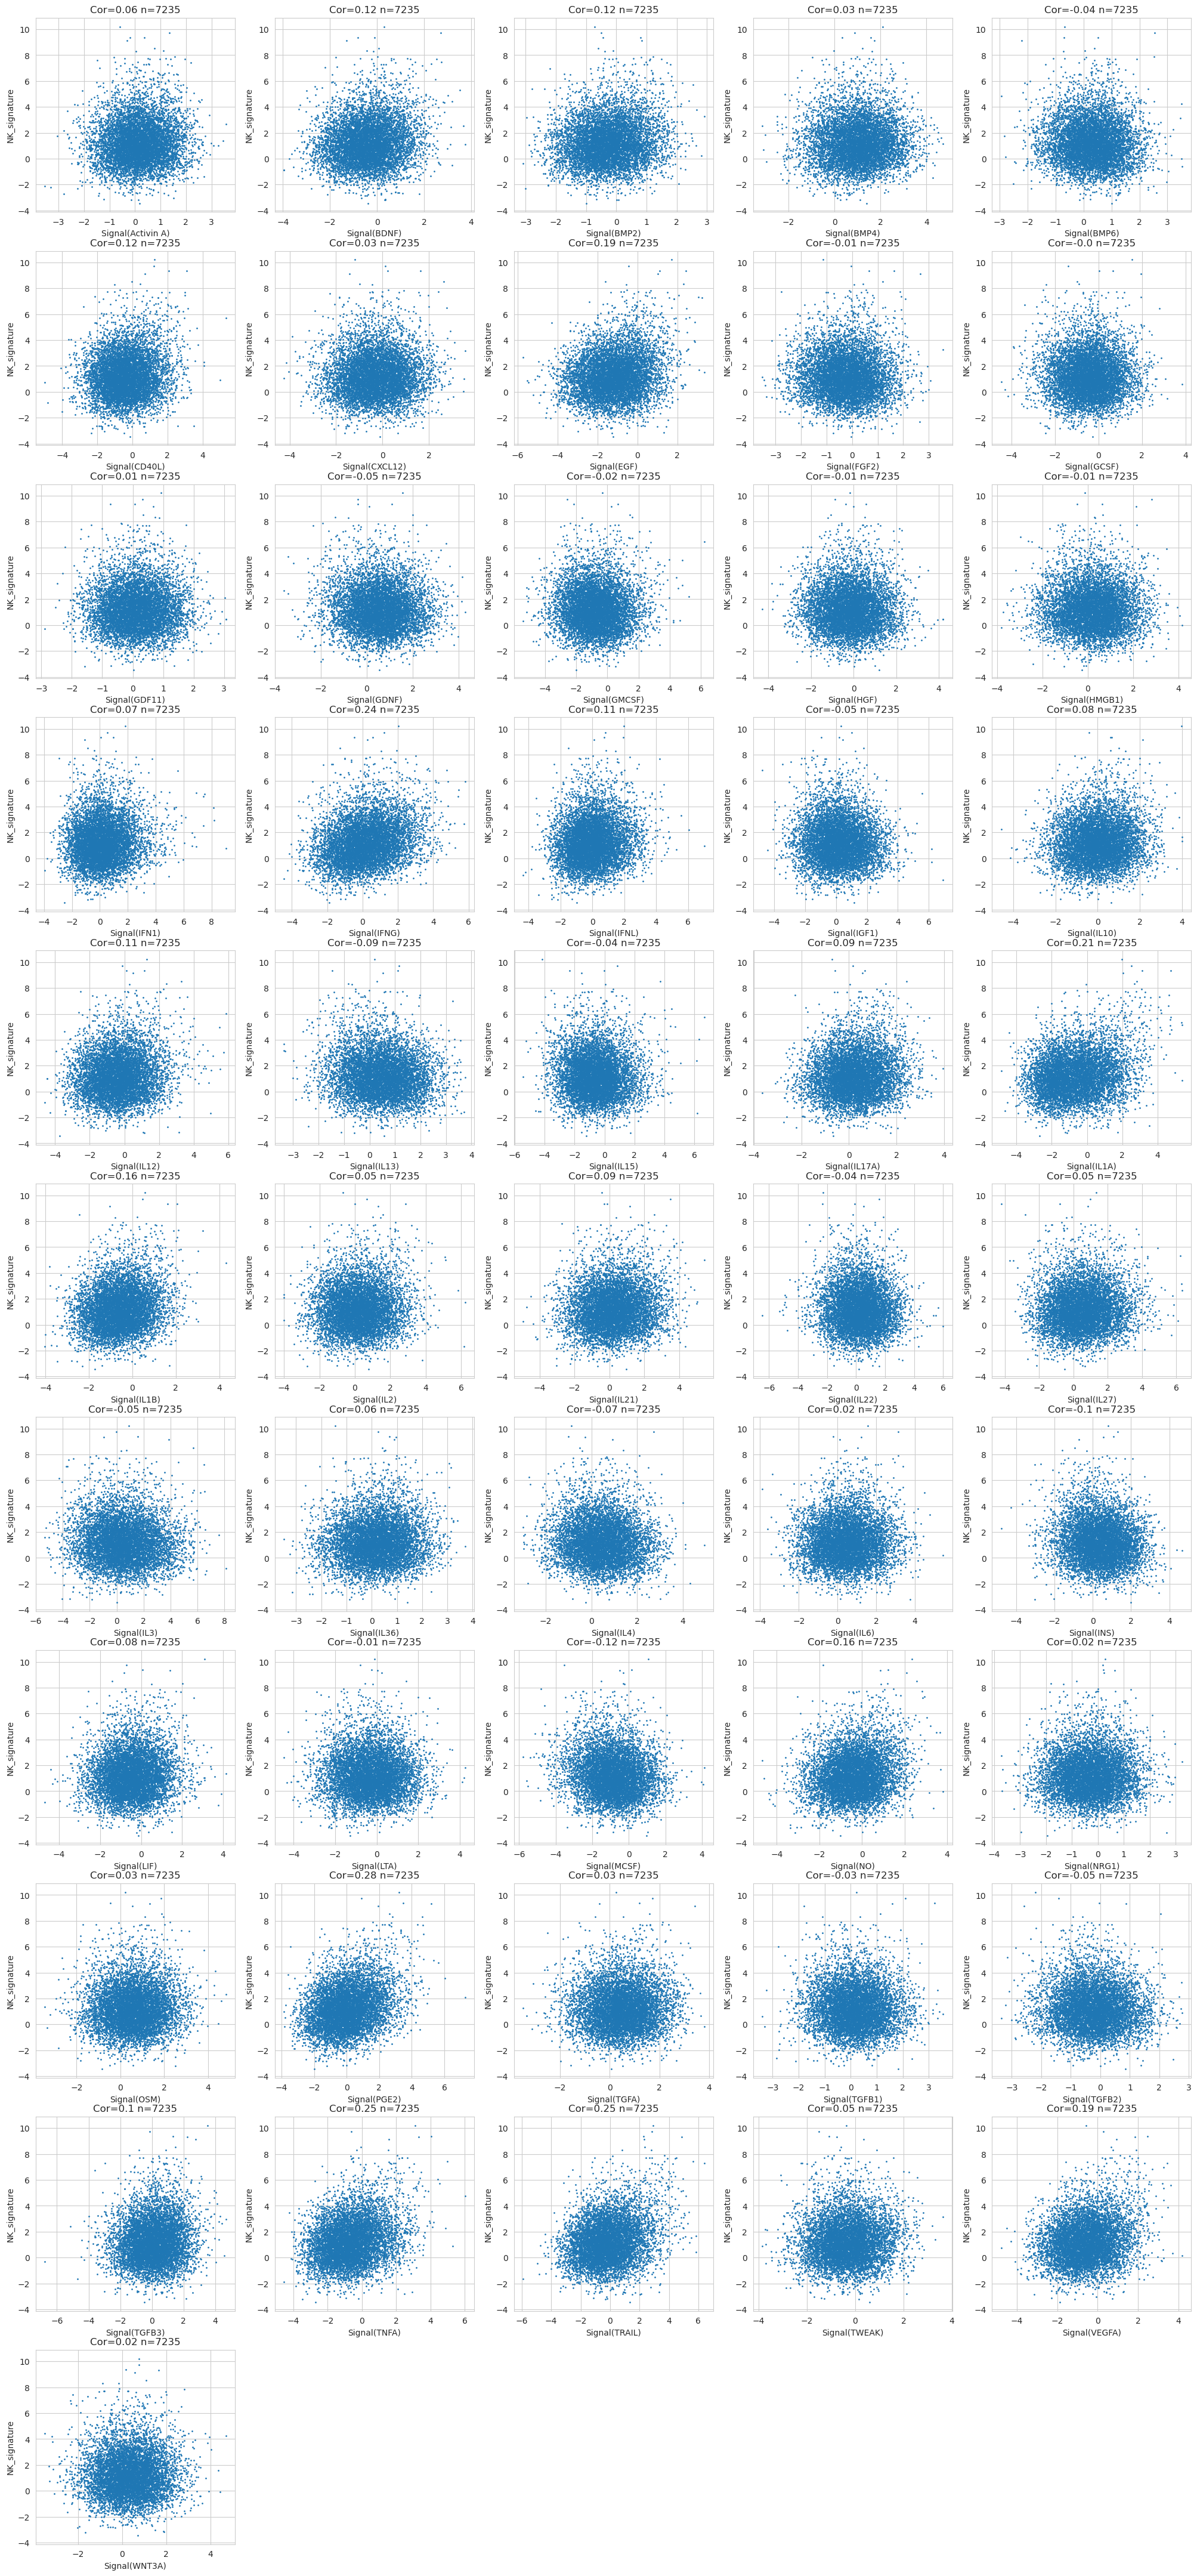

In [35]:
import matplotlib.gridspec as gridspec
from scipy.stats import pearsonr

fig = plt.figure(figsize=(25, 55))
ncols, nrows = 5, 11
gs = gridspec.GridSpec(nrows=nrows, ncols=ncols, width_ratios=[1] * ncols, height_ratios=[1] * nrows)

y = response_data.loc[signature]
i = 0
for cytokine in list(signaling_data.index):
    col = i % 5
    row = int(i / 5)
    ax = fig.add_subplot(gs[row, col])

    x = signaling_data.loc[cytokine]
    
    # x_normalized = (x - min(x)) / (max(x) - min(x))
    # y_normalized = (y - min(y)) / (max(y) - min(y))
    correlation, _ = pearsonr(x, y)
    
    ax.scatter(x, y, s=1)
    ax.set_xlabel(f'Signal({cytokine})')
    ax.set_ylabel(signature)
    ax.set_title(f'Cor={round(correlation, 2)} n={len(x)}')
    i += 1
# fig.title(f"Signaling-Response Correlation ({sample})")
plt.show()

## Response和Signaling相关性系数总结

/var/tmp/ipykernel_183931/1108301402.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  histplot.set_yticklabels(histplot.get_yticks(), size = 15)
/var/tmp/ipykernel_183931/1108301402.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  histplot.set_yticklabels(histplot.get_yticks(), size = 15)
/var/tmp/ipykernel_183931/1108301402.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  histplot.set_yticklabels(histplot.get_yticks(), size = 15)
/var/tmp/ipykernel_183931/1108301402.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  histplot.set_yticklabels(histplot.get_yticks(), size = 15)


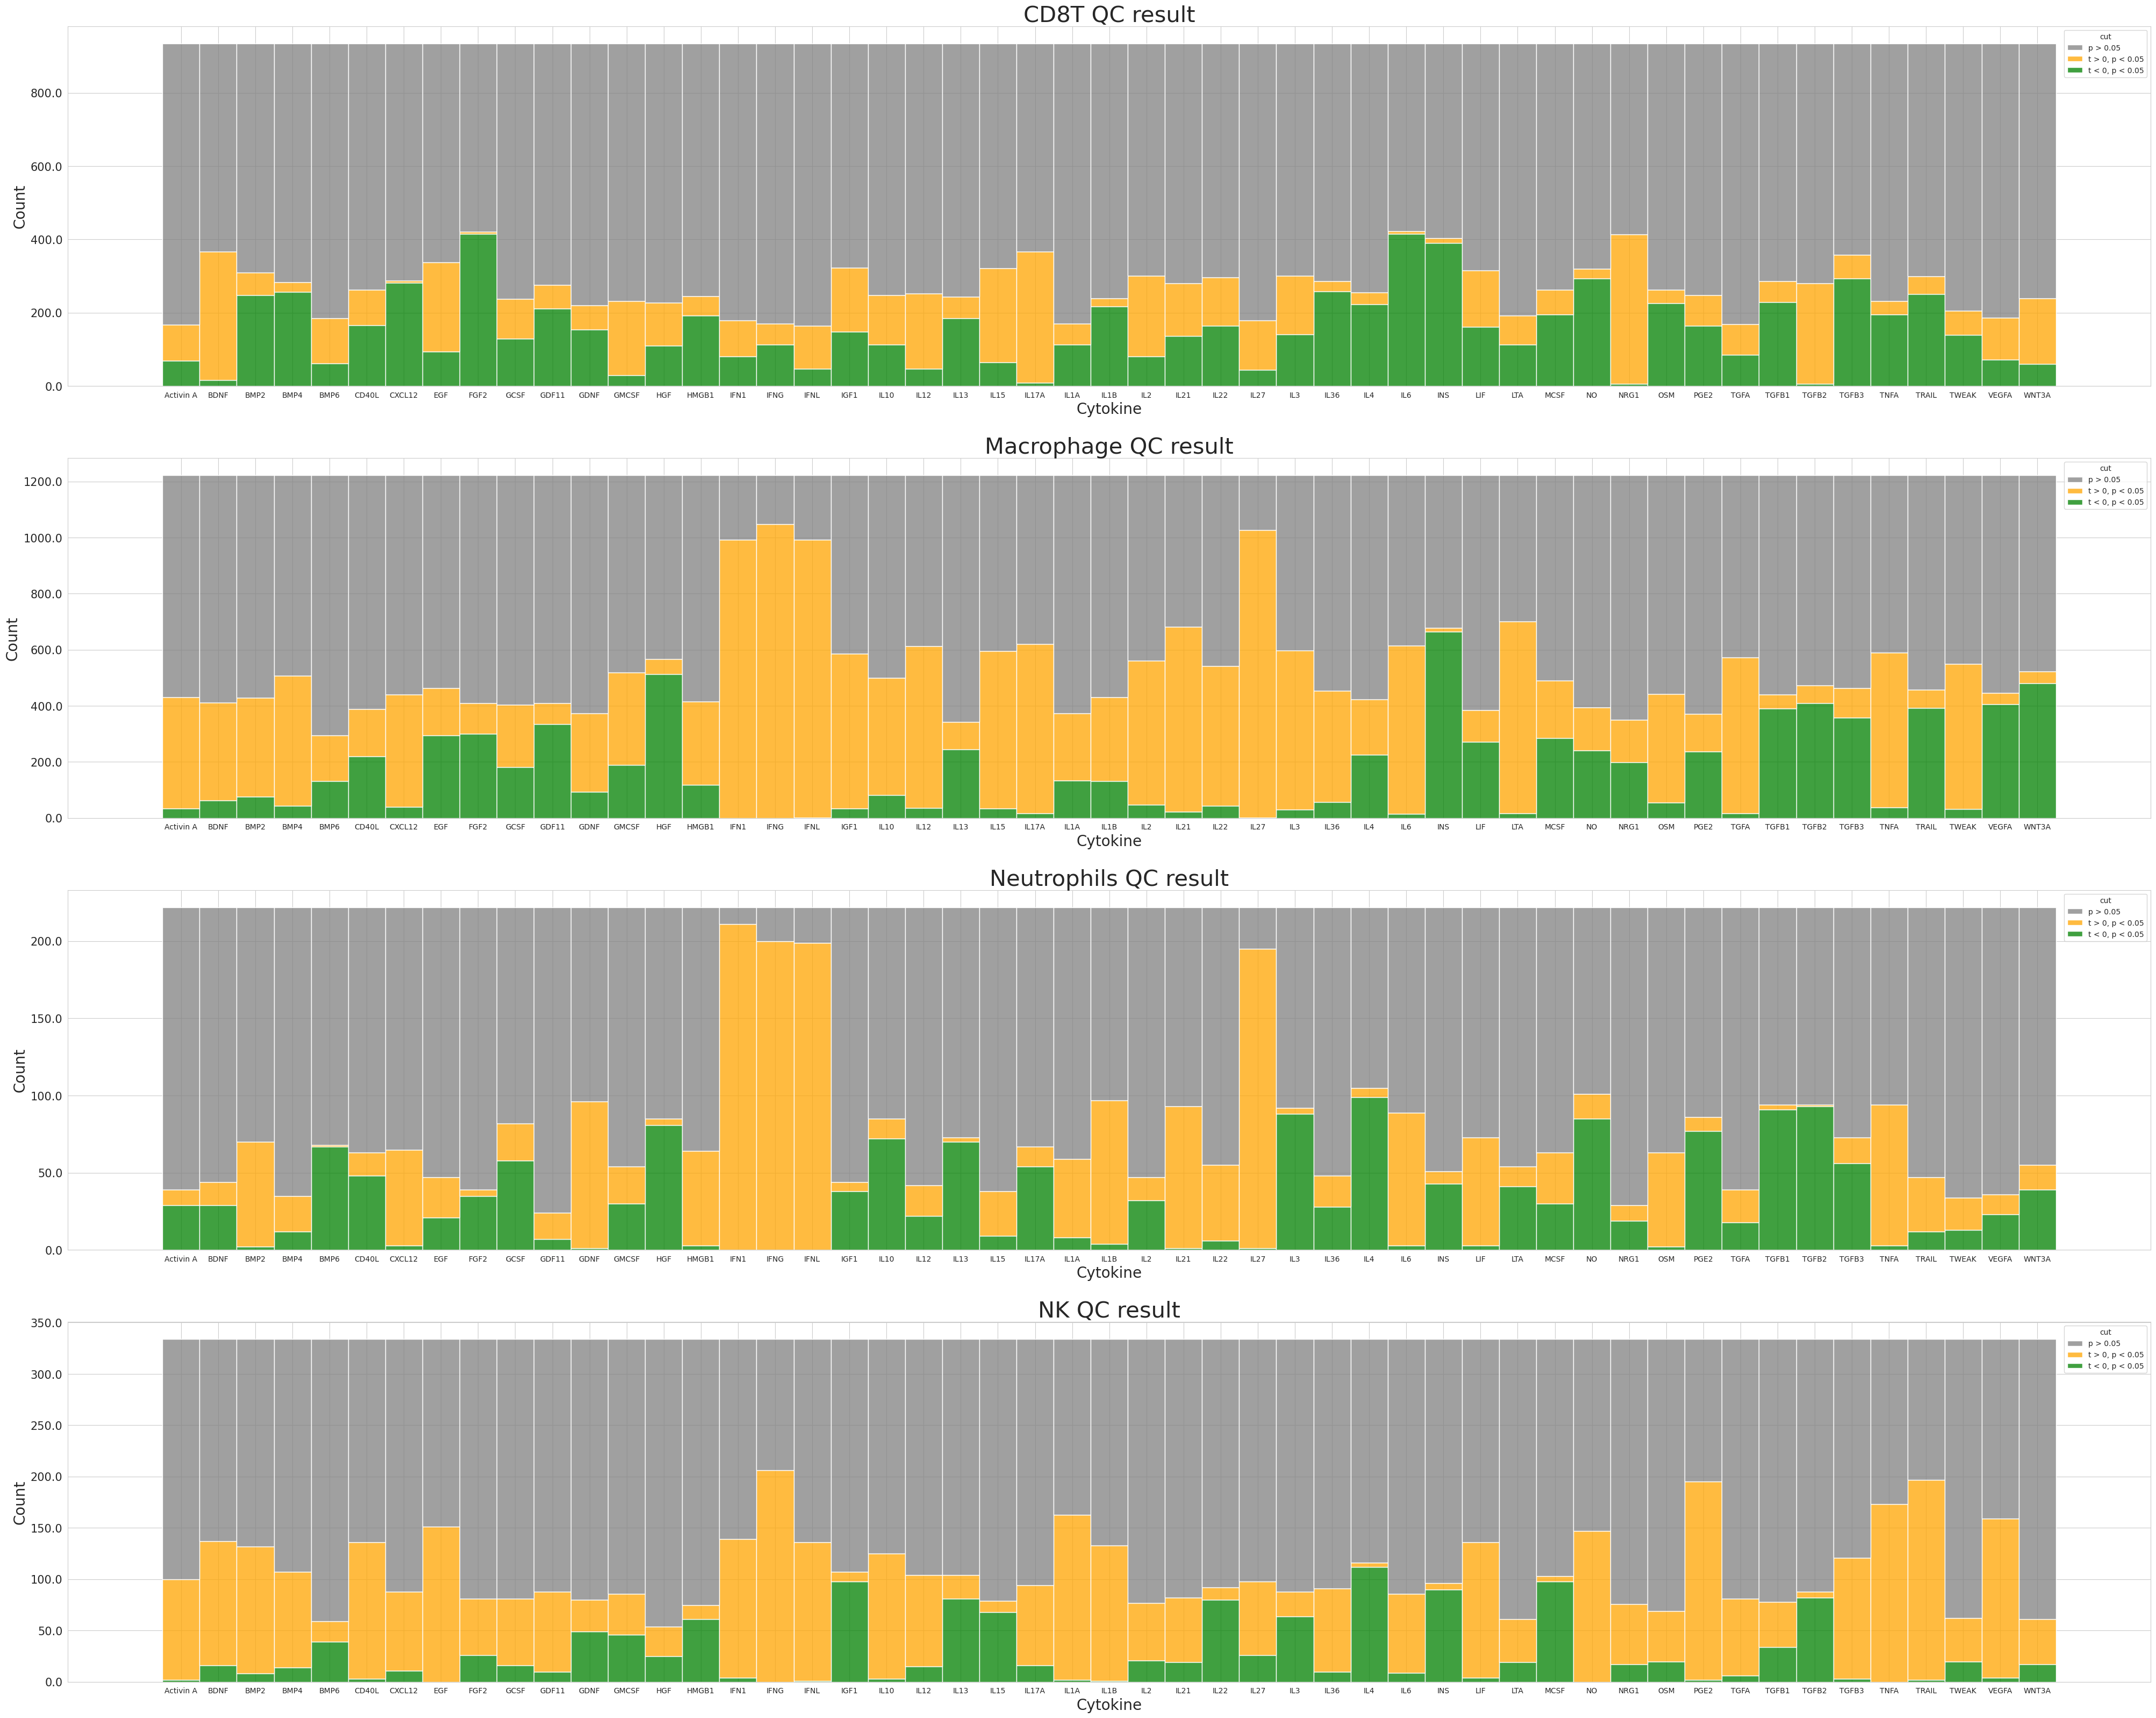

In [27]:
celltype_list = ['CD8T', 'Macrophage', 'Neutrophils', 'NK']
fig = plt.figure(figsize=(50, 10 * len(celltype_list)))
gs = gridspec.GridSpec(nrows=len(celltype_list), ncols=1)

i = 0
for celltype in celltype_list:
    if celltype == 'Neutrophils':
        qc_result_path = '/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/2.neutrophil_data/qc_result.Neutrophils.csv'
    else:
        qc_result_path = f'/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/2.tisch_data/4.qc_result/qc_result.{celltype}.csv'
    qc_result_data = pd.read_csv(qc_result_path, sep="\t", header=0)
    
    def get_group(x):
        if x.t >= 0 and x.p <= 0.05:
            return "t > 0, p < 0.05"
        elif x.t <= 0 and x.p <= 0.05:
            return "t < 0, p < 0.05"
        elif x.p > 0.05:
            return "p > 0.05"
    qc_result_data['cut'] = qc_result_data.apply(lambda x: get_group(x), axis=1)
    
    ax = fig.add_subplot(gs[i, 0])
    histplot = sns.histplot(data=qc_result_data, x="Cytokine", hue="cut", multiple="stack", 
                            palette={'t > 0, p < 0.05':'orange', 't < 0, p < 0.05':'green', 'p > 0.05':'grey'})
    histplot.xaxis.label.set_size(20)
    histplot.yaxis.label.set_size(20)
    histplot.set_yticklabels(histplot.get_yticks(), size = 15)
    histplot.set_title(f"{celltype} QC result", size = 30)
    i += 1
plt.show()

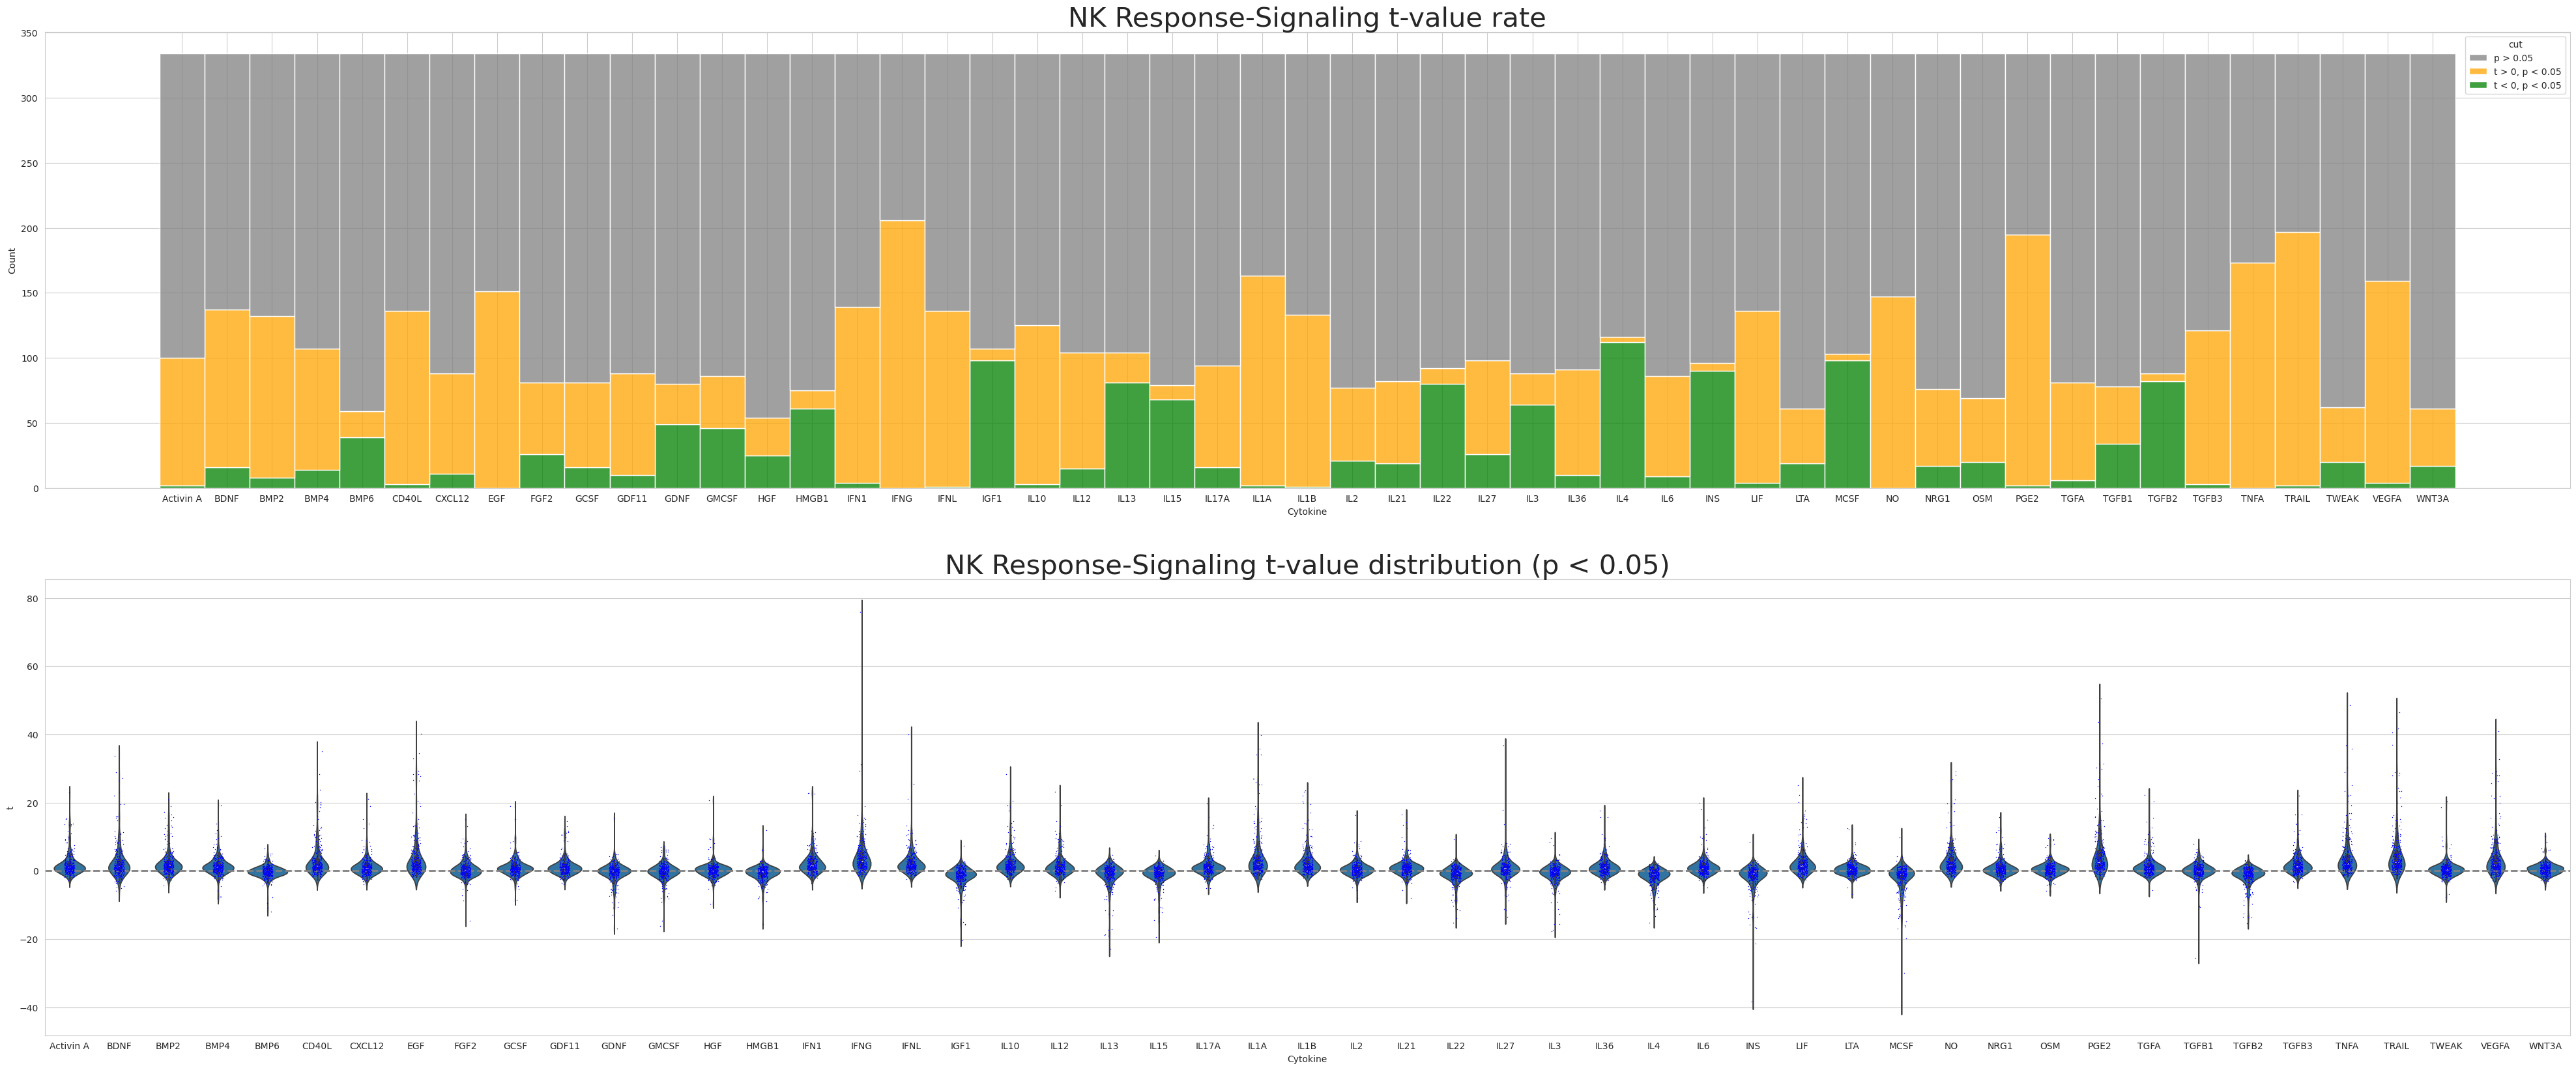

In [31]:
# 加上散点图
fig, axes = plt.subplots(2, 1, figsize=(50, 20))
sns.histplot(data=qc_result_data, x="Cytokine", hue="cut", multiple="stack", ax=axes[0], 
            palette={'t > 0, p < 0.05':'orange', 't < 0, p < 0.05':'green', 'p > 0.05':'grey'})
axes[0].set_title(f"{celltype} Response-Signaling t-value rate", size=30)
# qc_result_data_filtered = qc_result_data[qc_result_data['p'] <= 0.05]
sns.violinplot(x="Cytokine", y="t", data=qc_result_data, ax=axes[1])
sns.stripplot(x="Cytokine", y="t", data=qc_result_data, color='b', size=1, ax=axes[1])
axes[1].axhline(0, color='grey', linestyle='--', linewidth=2)
axes[1].set_title(f"{celltype} Response-Signaling t-value distribution (p < 0.05)", size=30)
plt.show()

## Cytokine相关性小于0占比排序

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy

celltype = 'CD8T'
qc_result_path1 = '/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/1.paper_data/3.qc_result/qc_result.CD8T.csv'
qc_result_path2 = '/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/2.tisch_data/4.qc_result/qc_result.CD8T.csv'
qc_result_data1 = pd.read_csv(qc_result_path1, sep="\t", header=0)
qc_result_data2 = pd.read_csv(qc_result_path2, sep="\t", header=0)

def get_group(x):
    if x.t >= 0 and x.p <= 0.05:
        return 0
    elif x.t <= 0 and x.p <= 0.05:
        return 1
    elif x.p > 0.05:
        return -1

qc_result_data1['cut'] = qc_result_data1.apply(lambda x: get_group(x), axis=1)
qc_result_data2['cut'] = qc_result_data2.apply(lambda x: get_group(x), axis=1)
qc_result_filtered1 = qc_result_data1[qc_result_data1['cut'] >= 0]
qc_result_filtered2 = qc_result_data2[qc_result_data2['cut'] >= 0]

qc_result_groupby_Cytokine1 = qc_result_filtered1.groupby('Cytokine')
qc_result_groupby_Cytokine2 = qc_result_filtered2.groupby('Cytokine')

cut_mean1 = qc_result_groupby_Cytokine1['cut'].mean()
cut_mean2 = qc_result_groupby_Cytokine2['cut'].mean()

X = cut_mean1.values
Y = cut_mean2.values
label = cut_mean1.index

# save the t<0 rate rank
rank_table = pd.DataFrame(index=label, columns=['Cohort_rank', 'Tisch_rank', 'average'])
Cohort_rank = scipy.stats.rankdata(X, method='min')
Tisch_rank = scipy.stats.rankdata(Y, method='min')
average = (Cohort_rank + Tisch_rank) / 2
rank_table['Cohort_rank'] = Cohort_rank
rank_table['Tisch_rank'] = Tisch_rank
rank_table['average'] = average
rank_table_sort = rank_table.sort_values(by='average')
rank_table_sort.to_csv(f"/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/2.tisch_data/4.qc_result/Rank.{celltype}.csv")

fig = plt.figure(figsize=(10, 10))
plt.scatter(X, Y)
for i in range(len(X)):
    plt.annotate(label[i], xy = (X[i], Y[i]), xytext = (X[i], Y[i]), fontsize = 5)
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.title('Cohort_Tisch Cytokine t<0 rate')
plt.xlabel('Cohort')
plt.ylabel('Tisch')
plt.show()

In [13]:
celltype = 'Neutrophils'
# qc_result_path = f'/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/2.tisch_data/4.qc_result/qc_result.{celltype}.csv'
qc_result_path = '/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/2.neutrophil_data/qc_result.Neutrophils.csv'
qc_result_data = pd.read_csv(qc_result_path, sep="\t", header=0)

def get_group(x):
    if x.t >= 0 and x.p <= 0.05:
        return 0
    elif x.t <= 0 and x.p <= 0.05:
        return 1
    elif x.p > 0.05:
        return -1

qc_result_data['negative_rate'] = qc_result_data.apply(lambda x: get_group(x), axis=1)
qc_result_filtered = qc_result_data[qc_result_data['negative_rate'] >= 0]
negative_rate = qc_result_filtered.groupby('Cytokine')['negative_rate'].mean()
negative_rate.sort_values(ascending=False, inplace=True)
negative_rate.to_csv(f"/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/2.neutrophil_data/Rank.{celltype}.csv")
negative_rate

Cytokine
TGFB2        0.989362
BMP6         0.985294
TGFB1        0.968085
IL13         0.958904
IL3          0.956522
HGF          0.952941
IL4          0.942857
FGF2         0.897436
PGE2         0.895349
IGF1         0.863636
IL10         0.847059
INS          0.843137
NO           0.841584
IL17A        0.805970
TGFB3        0.767123
CD40L        0.761905
LTA          0.759259
Activin A    0.743590
WNT3A        0.709091
GCSF         0.707317
IL2          0.680851
BDNF         0.659091
NRG1         0.655172
VEGFA        0.638889
IL36         0.583333
GMCSF        0.555556
IL12         0.523810
MCSF         0.476190
TGFA         0.461538
EGF          0.446809
TWEAK        0.382353
BMP4         0.342857
GDF11        0.291667
TRAIL        0.255319
IL15         0.236842
IL1A         0.135593
IL22         0.109091
HMGB1        0.046875
CXCL12       0.046154
IL1B         0.041237
LIF          0.041096
IL6          0.033708
TNFA         0.031915
OSM          0.031746
BMP2         0.028571
I